In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import ExtraTreesClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
trainData = pd.read_csv("PM_train.txt",sep=" ",header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10',
             's11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
trainData.columns=col_names
print("Train Data Shape: ", trainData.shape)
trainData.head()

Train Data Shape:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
testData = pd.read_csv('PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
testData.columns = col_names
print('Shape of Test dataset: ',testData.shape)
testData.head()

Shape of Test dataset:  (13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [4]:
trainData.isnull().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

In [5]:
trainData.isna().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

In [6]:
trainData.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [7]:
testData.isna().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

In [8]:
testData.describe().T

,count,mean,std,min,25%,50%,75%,max
id,13096.0,51.543907,2.828942e+01,1.0000,28.0000,52.0000,76.0000,100.0000
cycle,13096.0,76.836515,5.305775e+01,1.0000,33.0000,69.0000,113.0000,303.0000
setting1,13096.0,-0.000011,2.202685e-03,-0.0082,-0.0015,0.0000,0.0015,0.0078
setting2,13096.0,0.000004,2.940306e-04,-0.0006,-0.0002,0.0000,0.0003,0.0007
setting3,13096.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,13096.0,518.670000,6.014263e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,13096.0,642.475088,4.008993e-01,641.1300,642.1975,642.4600,642.7400,644.3000
s3,13096.0,1588.099204,5.003274e+00,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
s4,13096.0,1404.735362,6.688309e+00,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
s5,13096.0,14.620000,2.671743e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [9]:
pm_truth = pd.read_csv('PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns = ['more']
pm_truth['id'] = pm_truth.index + 1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [10]:
# Remaining useful life
rul = pd.DataFrame(testData.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [11]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [12]:
# Time to failure
testData=testData.merge(pm_truth,on=['id'],how='left')
testData['ttf']=testData['rtf'] - testData['cycle']
testData.drop('rtf', axis=1, inplace=True)
testData.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,more,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,112,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,112,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,112,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,112,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,112,138


In [13]:
# The assumption according to NASA reference is that the last cycle of each machine shows the failure of the machine.
trainData['ttf'] = trainData.groupby(['id'])['cycle'].transform(max)-trainData['cycle']
trainData.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [14]:
trainDataFrame = trainData
testDataFrame = testData
period = 30 # binary classification to predict how many days the machine will fail.
trainDataFrame['label_bc'] = trainDataFrame['ttf'].apply(lambda x: 1 if x <= period else 0)
testDataFrame['label_bc'] = testDataFrame['ttf'].apply(lambda x: 1 if x <= period else 0)
trainDataFrame.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [15]:
# For visualization, data is resampled
trainDataResample = trainData.loc[trainData.groupby(trainData.index//100).id.idxmax(), :]

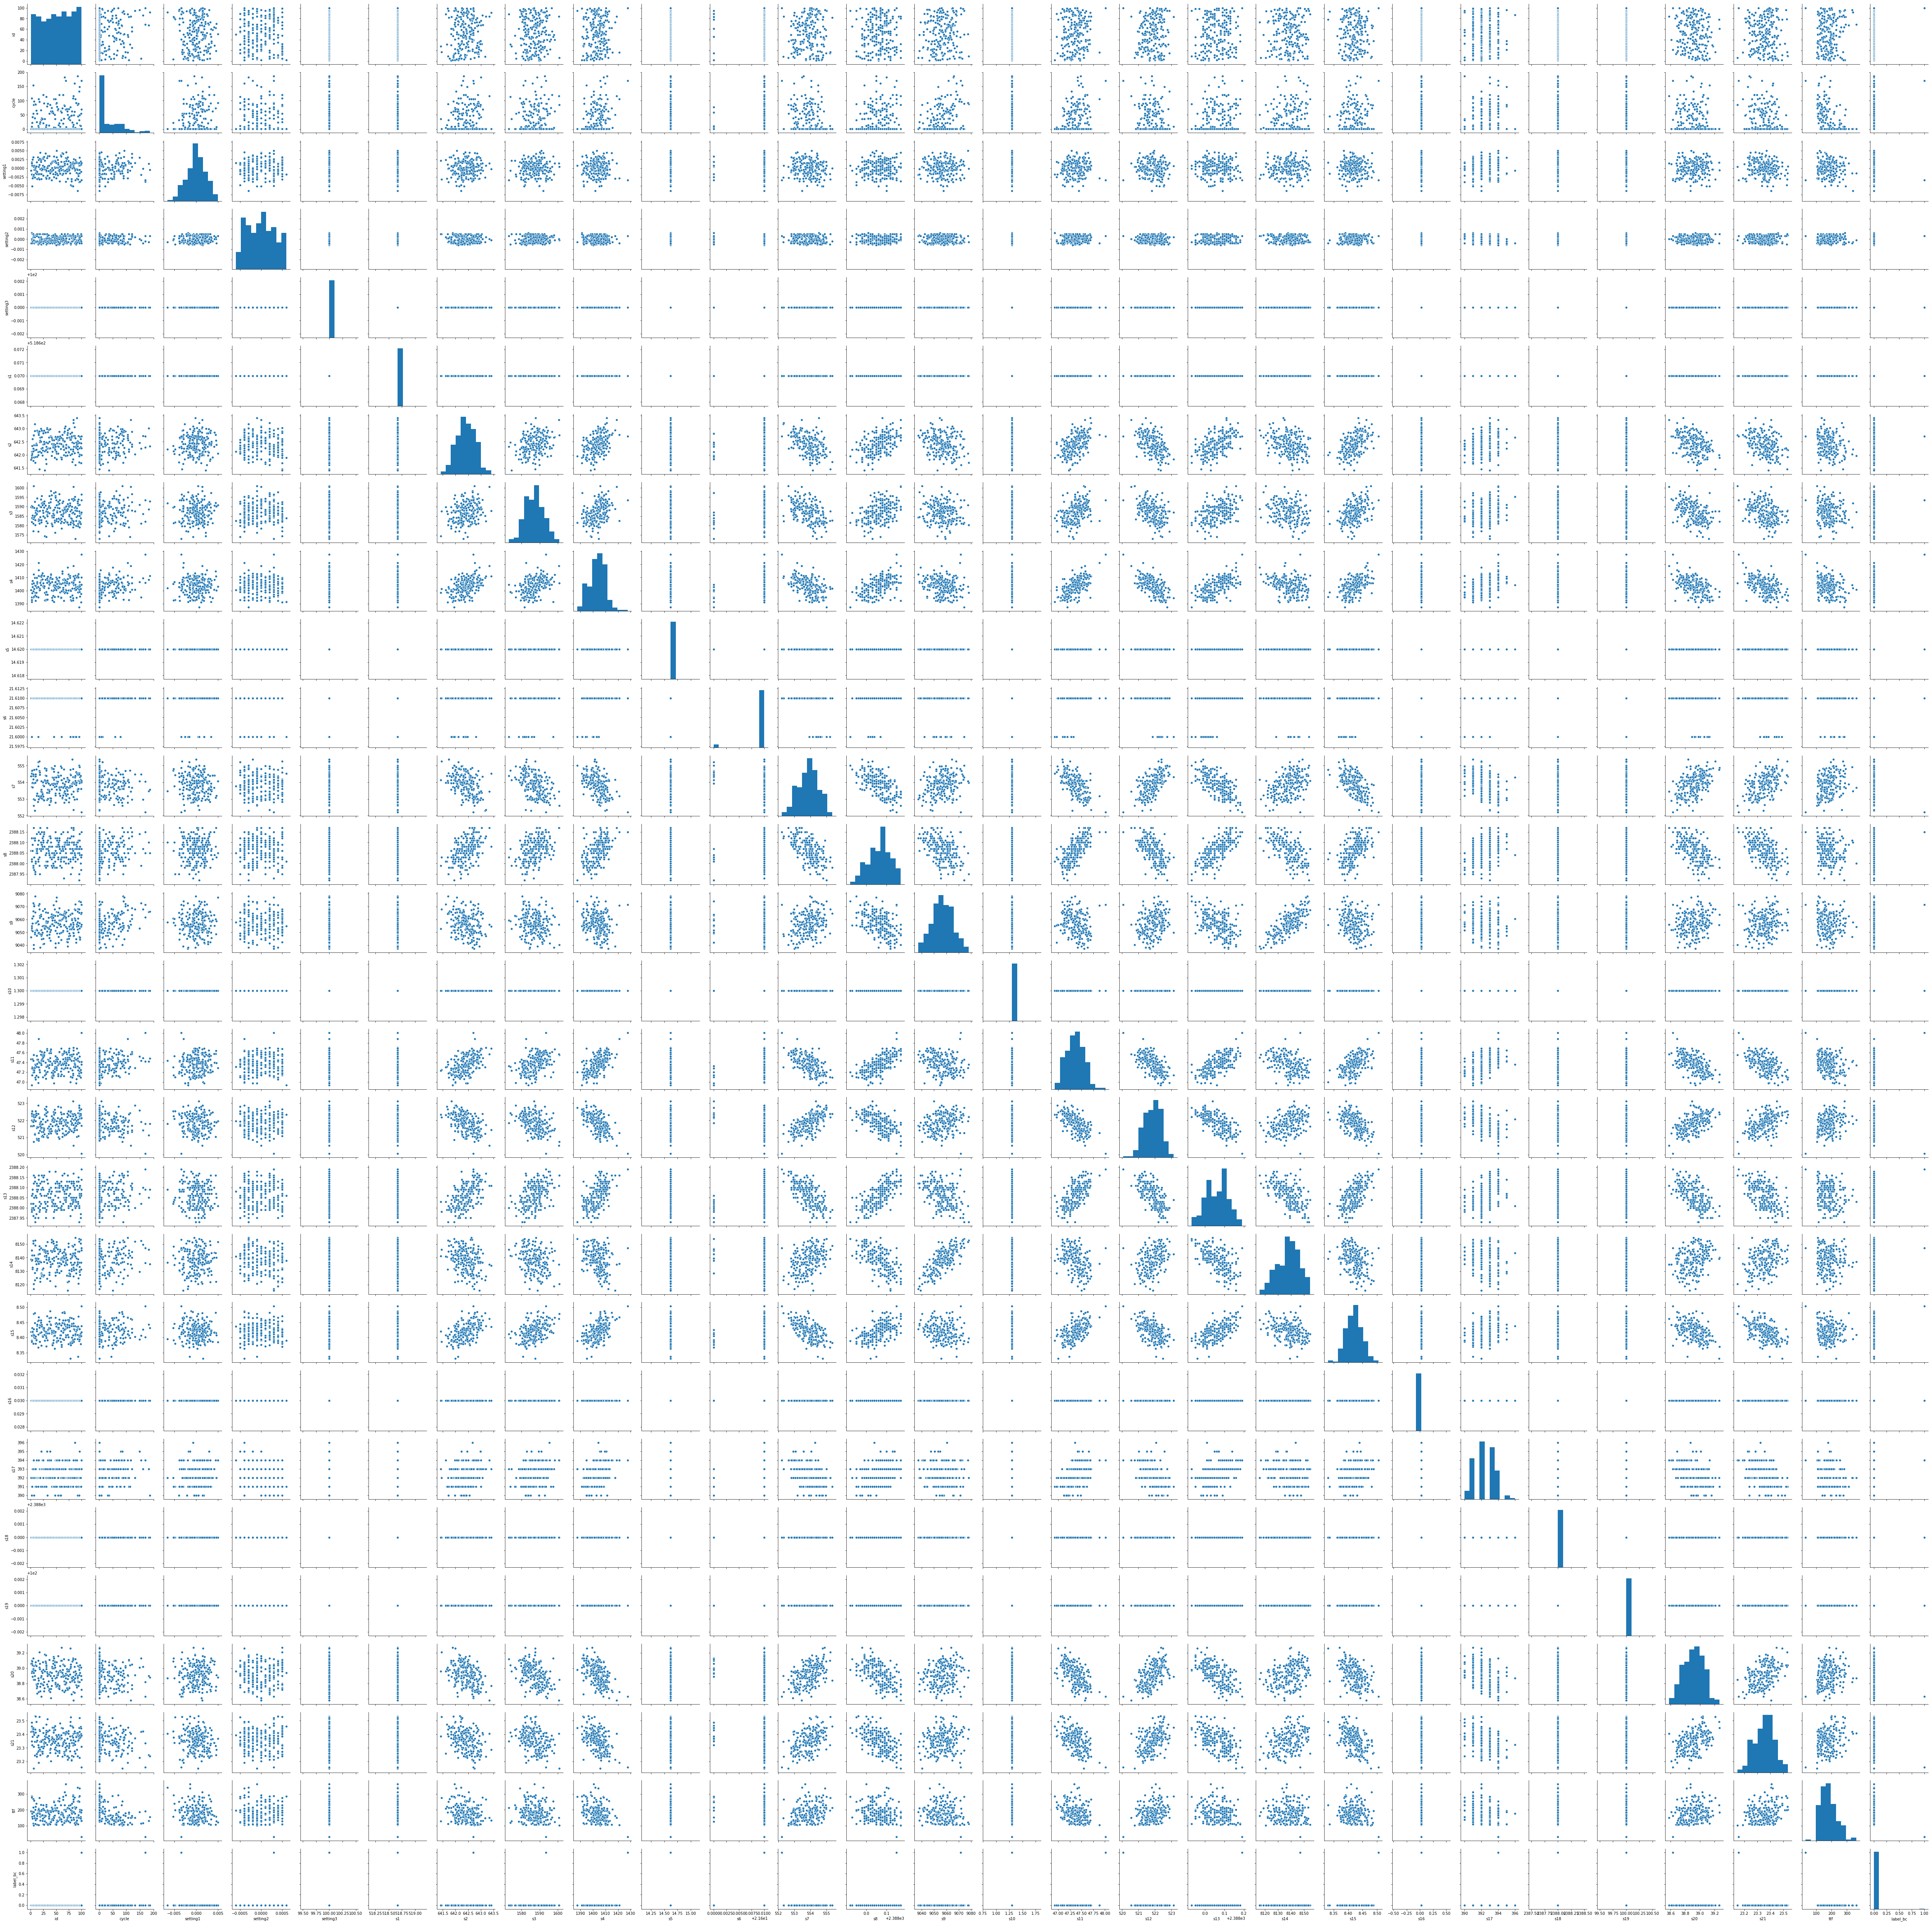

In [16]:
sns.pairplot(trainDataResample)

In [17]:
for featureName in trainData.columns:
    stat, p = shapiro(trainData[featureName])
    print(featureName, ": Statistics = %.3f, p-value = %.3f" %(stat, p))

id : Statistics = 0.951, p-value = 0.000
cycle : Statistics = 0.969, p-value = 0.000
setting1 : Statistics = 1.000, p-value = 0.005
setting2 : Statistics = 0.954, p-value = 0.000
setting3 : Statistics = 1.000, p-value = 1.000
s1 : Statistics = 1.000, p-value = 1.000
s2 : Statistics = 0.993, p-value = 0.000
s3 : Statistics = 0.994, p-value = 0.000
s4 : Statistics = 0.984, p-value = 0.000
s5 : Statistics = 1.000, p-value = 1.000
s6 : Statistics = 0.007, p-value = 0.000
s7 : Statistics = 0.988, p-value = 0.000
s8 : Statistics = 0.020, p-value = 0.000
s9 : Statistics = 0.774, p-value = 0.000
s10 : Statistics = 1.000, p-value = 1.000
s11 : Statistics = 0.982, p-value = 0.000
s12 : Statistics = 0.981, p-value = 0.000
s13 : Statistics = 0.113, p-value = 0.000
s14 : Statistics = 0.806, p-value = 0.000
s15 : Statistics = 0.989, p-value = 0.000
s16 : Statistics = 1.000, p-value = 1.000
s17 : Statistics = 0.955, p-value = 0.000
s18 : Statistics = 1.000, p-value = 1.000
s19 : Statistics = 1.000, p

In [18]:
levene(trainData["setting1"],trainData["setting2"],trainData["setting3"],trainData["s1"],trainData["s2"],
       trainData["s3"],trainData["s4"],trainData["s5"],trainData["s6"],trainData["s7"],trainData["s8"],
       trainData["s9"],trainData["s10"],trainData["s11"],trainData["s12"],trainData["s13"],trainData["s14"],
       trainData["s15"],trainData["s16"],trainData["s17"],trainData["s18"],trainData["s19"],trainData["s20"],
       trainData["s21"])

LeveneResult(statistic=11777.637787035419, pvalue=0.0)

In [19]:
f_oneway(trainData["setting1"],trainData["setting2"],trainData["setting3"],trainData["s1"],trainData["s2"],
       trainData["s3"],trainData["s4"],trainData["s5"],trainData["s6"],trainData["s7"],trainData["s8"],
       trainData["s9"],trainData["s10"],trainData["s11"],trainData["s12"],trainData["s13"],trainData["s14"],
       trainData["s15"],trainData["s16"],trainData["s17"],trainData["s18"],trainData["s19"],trainData["s20"],
       trainData["s21"])

F_onewayResult(statistic=2942477473.6594973, pvalue=0.0)

In [20]:
levene(trainData["s20"],trainData["s21"])

LeveneResult(statistic=4208.219446251358, pvalue=0.0)

In [21]:
f_oneway(trainData["s20"],trainData["s21"])

F_onewayResult(statistic=112049560.21600187, pvalue=0.0)

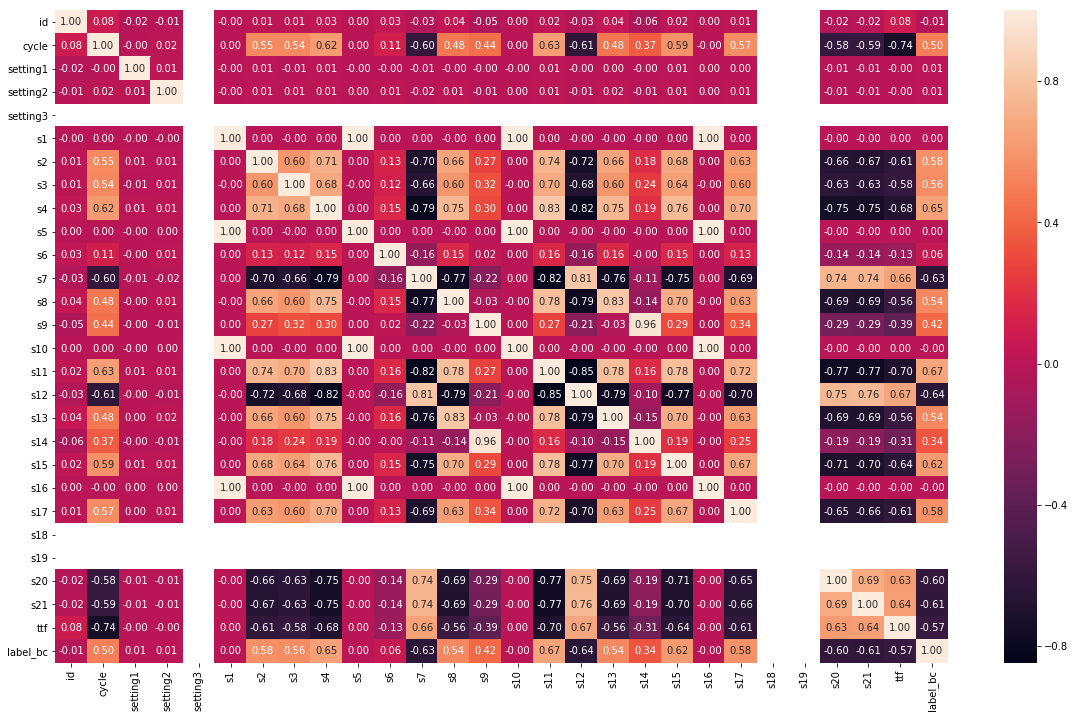

In [22]:
plt.figure(figsize=(20, 12))
sns.heatmap(trainData.corr(),annot=True,fmt=".2f")

In [23]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

In [24]:
sc = MinMaxScaler()
trainDataFrame[features_col_name] = sc.fit_transform(trainDataFrame[features_col_name])
testDataFrame[features_col_name] = sc.transform(testDataFrame[features_col_name])

In [25]:
model = ExtraTreesClassifier()
model.fit(trainDataFrame.drop(columns="label_bc"),trainDataFrame["label_bc"])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

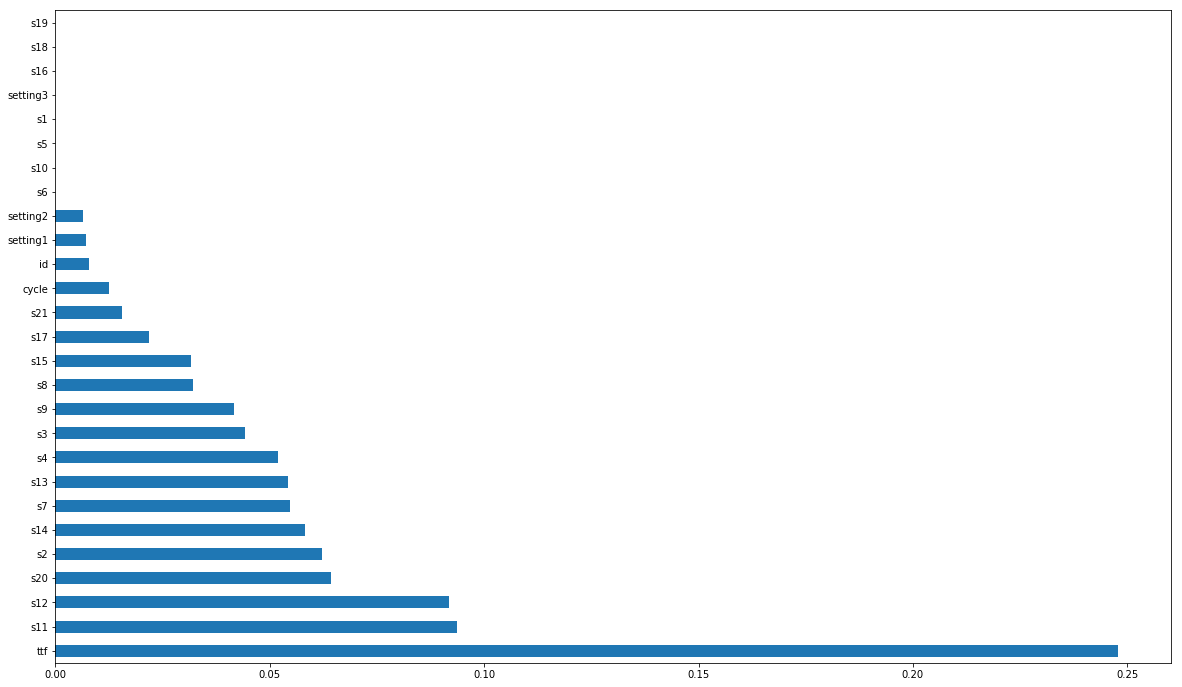

In [26]:
feat_importances = pd.Series(model.feature_importances_, index=trainDataFrame.drop(columns="label_bc").columns)
plt.figure(figsize=(20, 12))
feat_importances.nlargest(len(trainDataFrame.drop(columns="label_bc").columns)).plot(kind='barh')
plt.show()

In [27]:
# s19, s18, s16, setting3, s1, s10, s5, s6 are totaly non-useful. The features that have higher than 0.05 value are 
# useful. 
trainDataFrame = trainDataFrame.drop(columns=["s19","s18","s16","setting3","s1","s10","s5","s6"])
testDataFrame = testDataFrame.drop(columns=["s19","s18","s16","setting3","s1","s10","s5","s6"])

In [28]:
trainDataFrame.head()

,id,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,ttf,label_bc
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0


In [29]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [30]:
# window size
seq_length=50
seq_cols=trainDataFrame.drop(columns="label_bc").columns

In [31]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(trainDataFrame[trainDataFrame['id']==id], seq_length, seq_cols)) 
                            for id in trainDataFrame['id'].unique()))
print(X_train.shape)
# generate y_train
y_train=np.concatenate(list(list(gen_label(trainDataFrame[trainDataFrame['id']==id], seq_length, seq_cols,'label_bc')) 
                            for id in trainDataFrame['id'].unique()))
print(y_train.shape)

(20531, 50, 19)
(20531,)


In [32]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(testDataFrame[testDataFrame['id']==id], seq_length, seq_cols)) 
                           for id in testDataFrame['id'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(testDataFrame[testDataFrame['id']==id], 50, seq_cols,'label_bc')) 
                           for id in testDataFrame['id'].unique()))
print(y_test.shape)

(12996, 50, 19)
(12996,)


## LSTM

In [33]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           48000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 78,251
Trainable params: 78,251
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.1, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 18477 samples, validate on 2054 samples
Epoch 1/10
18477/18477 [==============================] - 23s 1ms/step - loss: 0.1412 - acc: 0.9426 - val_loss: 0.0273 - val_acc: 0.9907
Epoch 2/10
18477/18477 [==============================] - 20s 1ms/step - loss: 0.0265 - acc: 0.9898 - val_loss: 0.0322 - val_acc: 0.9844


In [35]:
# training metrics
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

20531/20531 [==============================] - 8s 373us/step
Accurracy: 0.9931323423166606


In [36]:
y_pred=model.predict_classes(X_test)
print('Accuracy of model on test data: ',accuracy_score(y_test,y_pred))
print('scores {:.5f} precision_score on the test set.'.format(precision_score(y_test, y_pred)))
print('scores {:.5f} recall_score on the test set.'.format(recall_score(y_test, y_pred)))
print('scores {:.5f} f1_score on the test set.'.format(f1_score(y_test, y_pred,'binary')))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

Accuracy of model on test data:  0.997614650661742
scores 0.91460 precision_score on the test set.
scores 1.00000 recall_score on the test set.
scores 0.95540 f1_score on the test set.
Confusion Matrix: 
 [[12633    31]
 [    0   332]]


In [37]:
def prob_failure(machine_id):
    machine_df=testDataFrame[testDataFrame.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

In [38]:
for machine_id in range(100):
    print("Probability that machine-%d will fail within 30 days: %.5f %% \n" %(machine_id + 1, 
                                                                            prob_failure(machine_id + 1)))

Probability that machine-1 will fail within 30 days: 0.02920 % 

Probability that machine-2 will fail within 30 days: 0.05997 % 

Probability that machine-3 will fail within 30 days: 0.08393 % 

Probability that machine-4 will fail within 30 days: 0.07534 % 

Probability that machine-5 will fail within 30 days: 0.06242 % 

Probability that machine-6 will fail within 30 days: 0.06777 % 

Probability that machine-7 will fail within 30 days: 0.09276 % 

Probability that machine-8 will fail within 30 days: 0.09307 % 

Probability that machine-9 will fail within 30 days: 0.05891 % 

Probability that machine-10 will fail within 30 days: 0.09683 % 

Probability that machine-11 will fail within 30 days: 0.05946 % 

Probability that machine-12 will fail within 30 days: 0.09294 % 

Probability that machine-13 will fail within 30 days: 0.09842 % 

Probability that machine-14 will fail within 30 days: 0.04924 % 

Probability that machine-15 will fail within 30 days: 0.05553 % 

Probability that ma